 # Online Retail Data Analysis (UCI Machine Learning Repository)

### 1. Introduction
##### The introduction covers the objective, scope, and tools used for the analysis.

### 2. Customer Segmentation (RFM Analysis)
##### This section details the calculation of Recency, Frequency, and Monetary (RFM) scores, the application of clustering techniques like K-Means and Hierarchical clustering, and the visualization of customer segments.

### 3. Sales Trend Analysis & Forecasting
##### This part explores trend and seasonality detection, the use of forecasting models such as ARIMA, Facebook Prophet, and LSTM, and the evaluation of model performance.

### 4. Product Recommendation System
##### This section focuses on collaborative filtering, market basket analysis using the Apriori algorithm, and insights from the implementation.

### 5. Business Insights & Recommendations
##### This section highlights key findings and marketing strategies derived from the analysis.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import dask.dataframe as dd

In [4]:
import pandas as pd

# Load all sheets
df_dict = pd.read_excel('Online Retail.xlsx', sheet_name=None, engine='openpyxl')

# Keep only sheets with actual tables (non-empty DataFrames)
tables = {name: df for name, df in df_dict.items() if not df.empty}

# Display table names
print(tables.keys())

# Display first few rows of the first table
first_table = list(tables.keys())[0]
print(tables[first_table].head())



dict_keys(['Online Retail'])
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


## Data Cleaning and Handling Missing Values in Online Retail Dataset

#### Understanding Missing Values

In [5]:
import pandas as pd

# Load dataset
df = pd.read_excel('Online Retail.xlsx', sheet_name='Online Retail', engine='openpyxl')

# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


#### Handling Missing Values

In [6]:
## Drop Rows with Crucial Missing Data
df = df.dropna(subset=['CustomerID'])

## Fill Missing Descriptions (Fixing FutureWarning)
df['Description'] = df['Description'].fillna('Unknown Product')

## Check Duplicates
print(f"Duplicate Rows: {df.duplicated().sum()}")

## Remove Duplicates
df = df.drop_duplicates().reset_index(drop=True)

## Handling Incorrect or Invalid Data
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

## Convert Data Types for Consistency
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])



Duplicate Rows: 5225


In [7]:
df.reset_index(drop=True, inplace=True)

In [8]:
df.to_csv('Cleaned_Online_Retail.csv', index=False)


## Customer Segmentation Using RFM Analysis 
### 📌 Objective:
#### Segment customers based on Recency (R), Frequency (F), and Monetary (M) values to identify high-value customers, frequent buyers, and inactive customers for targeted marketing strategies.



In [9]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage


In [10]:
df['TotalSales'] = df['Quantity'] * df['UnitPrice']
# Define reference date (1 day after the last transaction in the dataset)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM Metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency (days)
    'InvoiceNo': 'nunique',  # Frequency (count of unique invoices)
    'TotalSales': 'sum'  # Monetary (total spent)
}).reset_index()

# Rename columns
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalSales': 'Monetary'}, inplace=True)

# Display RFM table
print(rfm.head())


   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40


#### Normalize RFM Scores

In [11]:
from sklearn.preprocessing import StandardScaler

# Standardize RFM scores
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


#### Apply K-Means Clustering

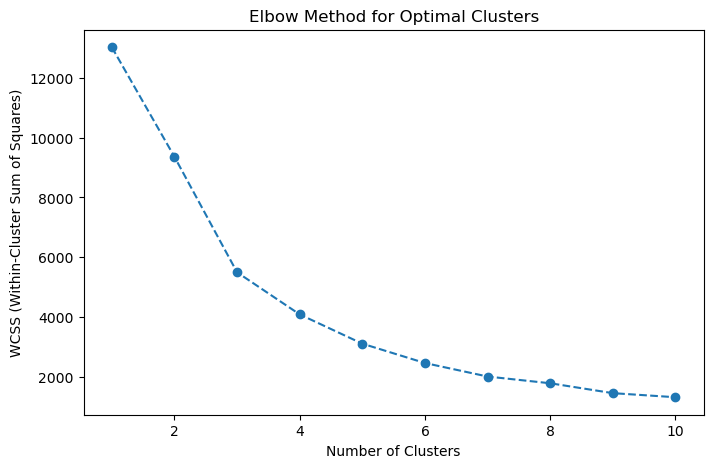

In [12]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal Clusters')
plt.show()


#### Train K-Means Model

In [13]:
# Choose k based on the Elbow method (e.g., k=4)
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# View Clusters
print(rfm.groupby('Cluster').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': 'mean'}))


            Recency  Frequency       Monetary
Cluster                                      
0         43.702685   3.682711    1353.625312
1        248.075914   1.552015     478.848773
2          7.384615  82.538462  127187.959231
3         15.500000  22.333333   12690.500392


#### Visualize Clusters

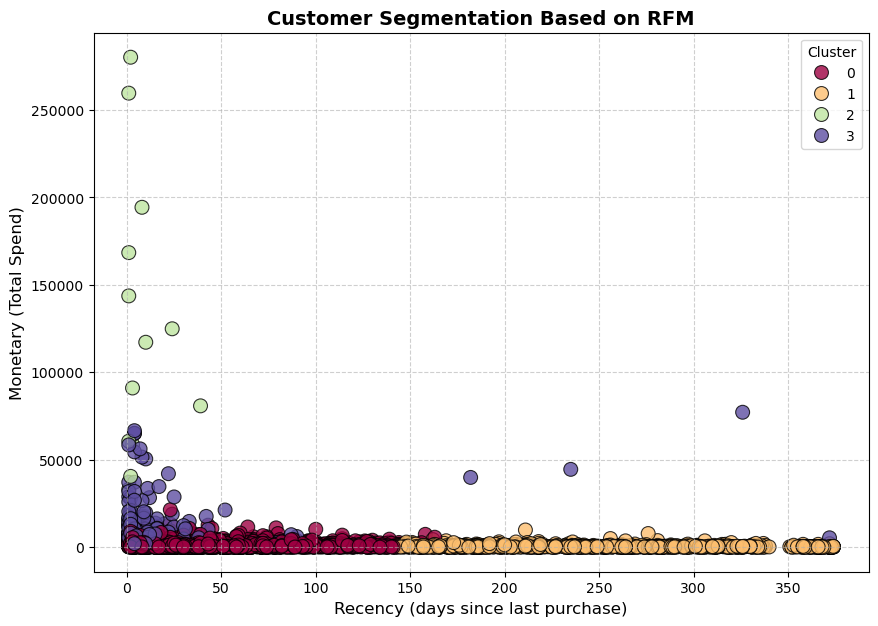

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))  # Larger figure size
sns.scatterplot(
    x=rfm['Recency'], 
    y=rfm['Monetary'], 
    hue=rfm['Cluster'], 
    palette='Spectral',   # Vibrant colors
    s=100,               # Larger dots
    edgecolor='black',   # Outline for visibility
    alpha=0.8            # Slight transparency
)

# Labels & Title
plt.xlabel('Recency (days since last purchase)', fontsize=12)
plt.ylabel('Monetary (Total Spend)', fontsize=12)
plt.title('Customer Segmentation Based on RFM', fontsize=14, fontweight='bold')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


### Conclusion
#### The visualization reveals distinct customer segments based on Recency and Monetary values. Higher-spending customers (Monetary) tend to have lower Recency, indicating frequent purchases, while lower-spending customers show higher Recency, suggesting inactivity. 🚀

## Apply Hierarchical Clustering

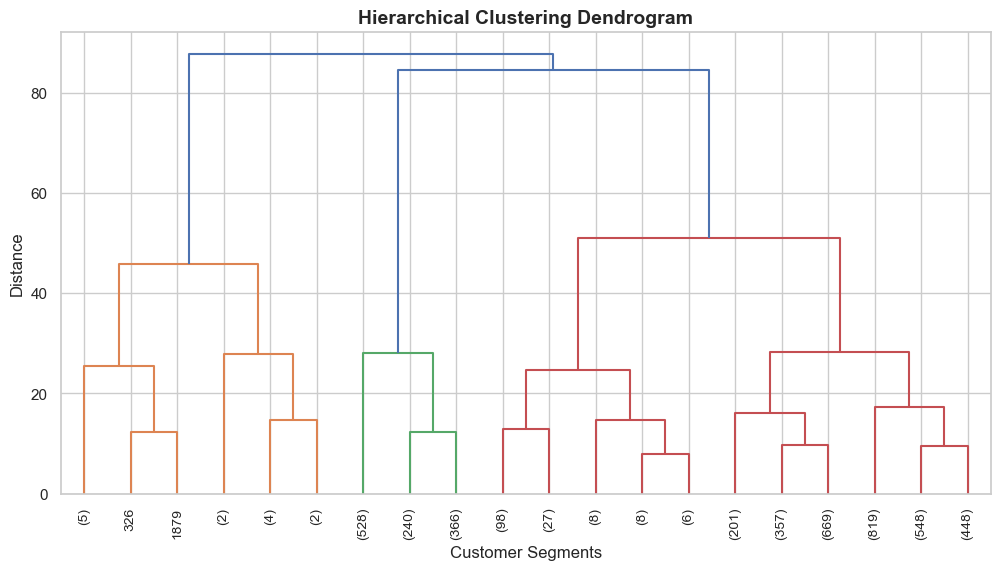

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# Create linkage matrix
linkage_matrix = linkage(rfm_scaled, method='ward')

# Set figure size and style
plt.figure(figsize=(12, 6))
sns.set(style='whitegrid')

# Plot dendrogram with better visibility
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # Only show last 'p' merged clusters
    p=20,                   # Show only the largest 20 clusters
    leaf_rotation=90,       # Rotate x-axis labels for better visibility
    leaf_font_size=10,      # Adjust font size
    color_threshold=0.7 * max(linkage_matrix[:, 2])  # Color clusters
)

# Labels & Title
plt.title('Hierarchical Clustering Dendrogram', fontsize=14, fontweight='bold')
plt.xlabel('Customer Segments', fontsize=12)
plt.ylabel('Distance', fontsize=12)

# Show the plot
plt.show()


## Sales Trend Analysis & Forecasting
#### Load & Prepare Data

In [16]:
import pandas as pd

# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Aggregate daily sales
df['TotalSales'] = df['Quantity'] * df['UnitPrice']
sales_data = df.groupby(df['InvoiceDate'].dt.date)['TotalSales'].sum().reset_index()
sales_data.columns = ['Date', 'TotalSales']

# Set Date as index
sales_data['Date'] = pd.to_datetime(sales_data['Date'])
sales_data.set_index('Date', inplace=True)


#### Visualize Sales Trends

D:\anaconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


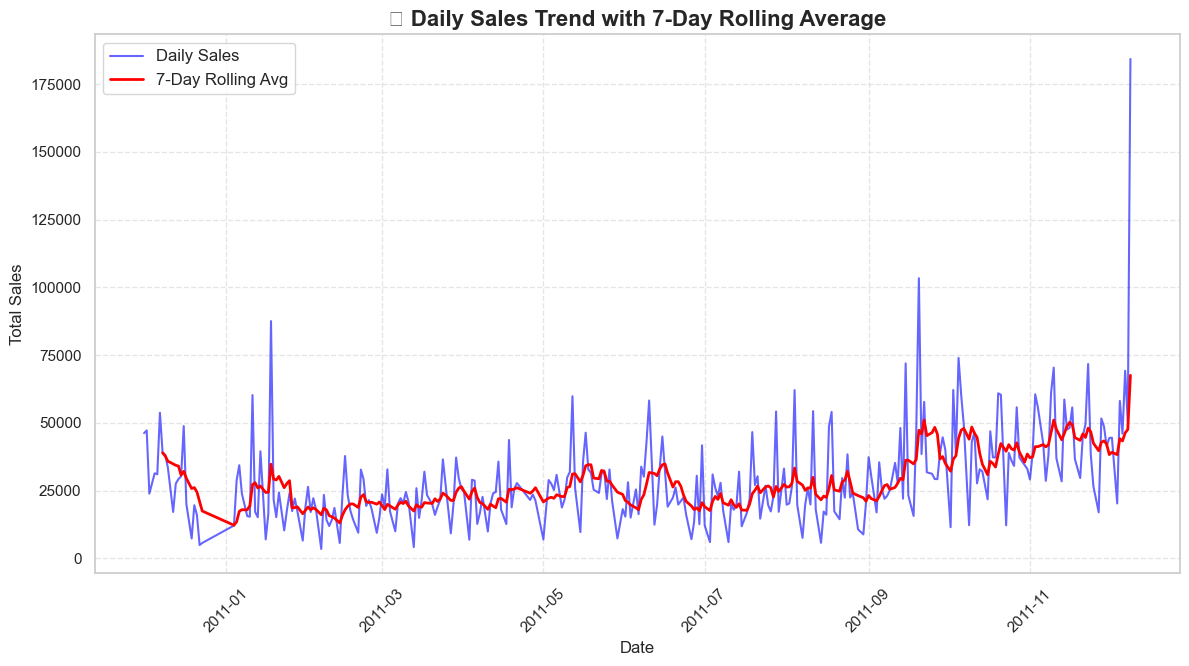

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute 7-day rolling average for smoother trend visualization
sales_data['RollingAvg'] = sales_data['TotalSales'].rolling(window=7).mean()

plt.figure(figsize=(14, 7))
sns.lineplot(data=sales_data, x=sales_data.index, y='TotalSales', color='blue', label='Daily Sales', alpha=0.6)
sns.lineplot(data=sales_data, x=sales_data.index, y='RollingAvg', color='red', label='7-Day Rolling Avg', linewidth=2)

# Customize title and labels
plt.title("📈 Daily Sales Trend with 7-Day Rolling Average", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)

# Improve legend
plt.legend(loc='upper left', fontsize=12)
plt.show()


#### Check Seasonality & Trends using Decomposition

C:\Users\RAMEEN SHAHID\AppData\Local\Temp\ipykernel_21428\502461291.py:21: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
D:\anaconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


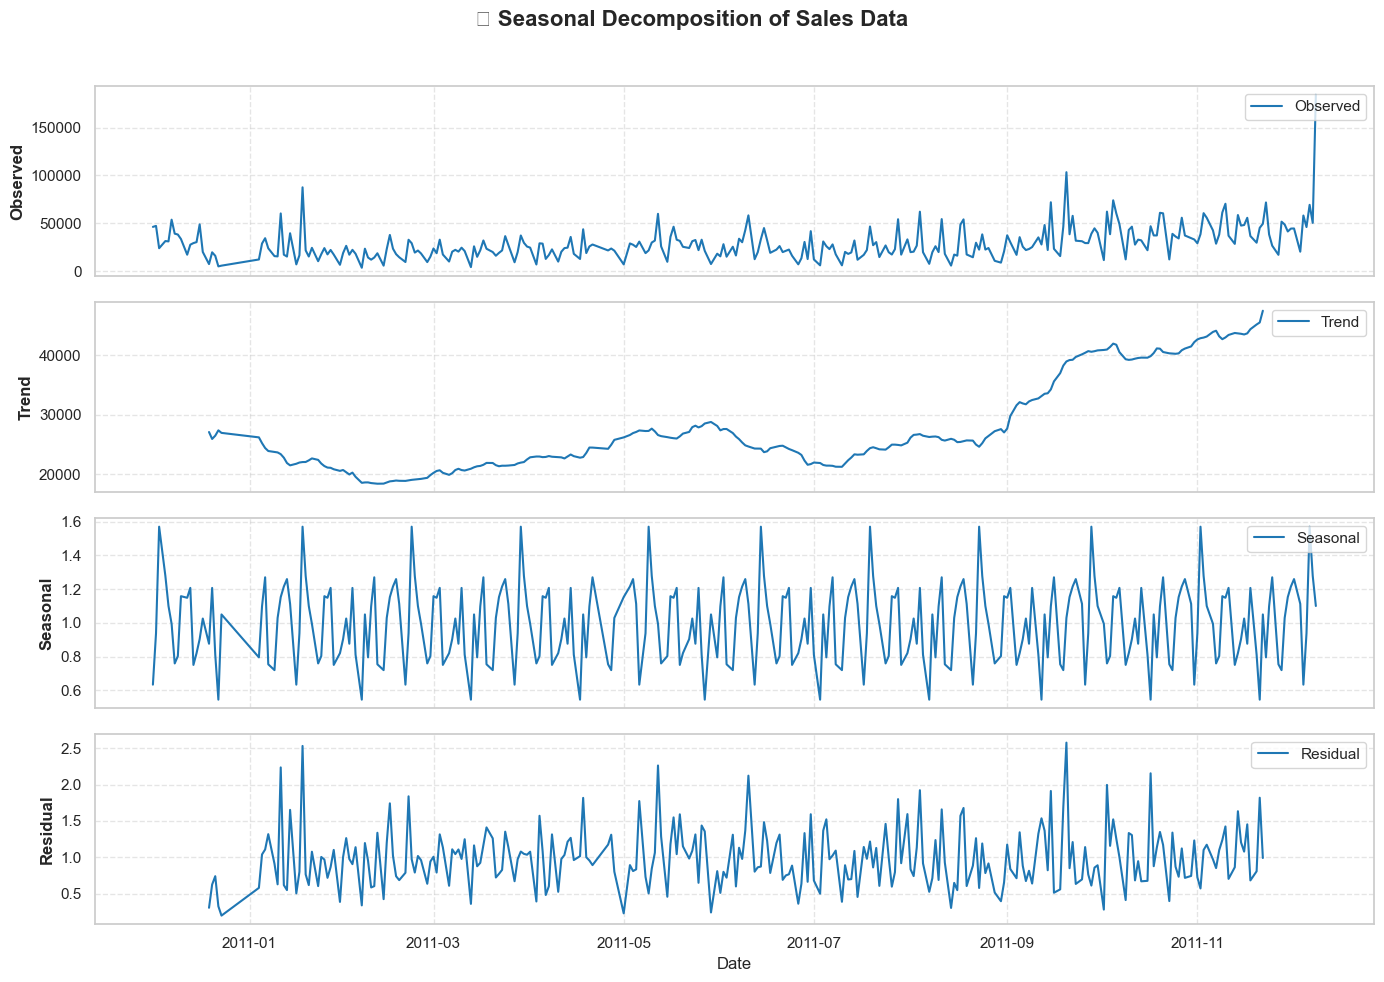

In [18]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
result = seasonal_decompose(sales_data['TotalSales'], model='multiplicative', period=30)

# Set figure size
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Plot each component with clear labels
components = ['Observed', 'Trend', 'Seasonal', 'Residual']
for i, comp in enumerate([result.observed, result.trend, result.seasonal, result.resid]):
    axes[i].plot(comp, label=components[i], color='tab:blue')
    axes[i].set_ylabel(components[i], fontsize=12, fontweight='bold')
    axes[i].grid(True, linestyle='--', alpha=0.5)
    axes[i].legend(loc='upper right')

# Improve layout and title
plt.suptitle("📈 Seasonal Decomposition of Sales Data", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()


#### Forecast Future Sales using ARIMA

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_m

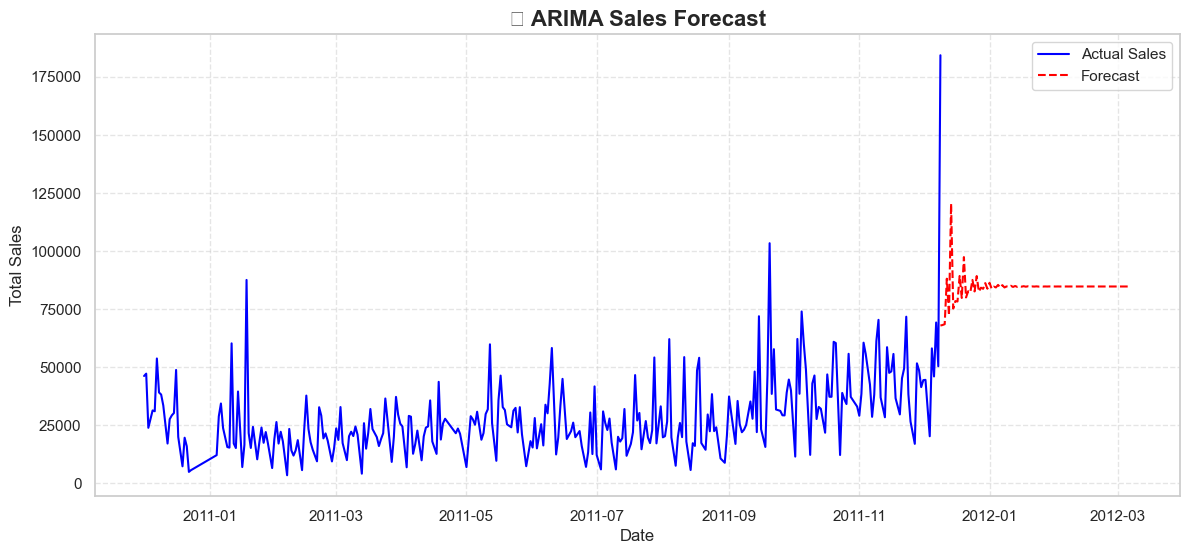

In [19]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'sales_data' index is datetime
sales_data.index = pd.to_datetime(sales_data.index)

# Fit ARIMA model (adjust p, d, q parameters as needed)
model = ARIMA(sales_data['TotalSales'], order=(5,1,2))  
arima_result = model.fit()

# Forecast for next 90 days
forecast = arima_result.forecast(steps=90)

# Plot results
plt.figure(figsize=(14, 6))
plt.plot(sales_data.index, sales_data['TotalSales'], label="Actual Sales", color="blue")
plt.plot(pd.date_range(sales_data.index[-1], periods=90, freq='D'), forecast, label="Forecast", color="red", linestyle="dashed")
plt.title("🔮 ARIMA Sales Forecast", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


## Product Recommendation System

#### Collaborative Filtering (User-Based & Item-Based)

In [20]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Create a User-Item matrix
user_item_matrix = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', fill_value=0)

# Compute similarity between customers
user_similarity = cosine_similarity(user_item_matrix)

# Convert to DataFrame for better visualization
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Function to get top N similar users
def get_similar_users(customer_id, n=5):
    return user_similarity_df[customer_id].sort_values(ascending=False).iloc[1:n+1]

# Example: Find top 5 similar customers for a given customer ID
similar_users = get_similar_users(customer_id=17850, n=5)
print(similar_users)


CustomerID
13161.0    0.386039
18105.0    0.304348
13831.0    0.288015
13514.0    0.266867
17616.0    0.265025
Name: 17850.0, dtype: float64


#### Market Basket Analysis (Apriori Algorithm)

In [21]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Load dataset
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df['StockCode'] = df['StockCode'].astype(str)

# Group by transactions and pivot into basket format
basket = df.groupby(['InvoiceNo', 'StockCode'])['Quantity'].sum().unstack().fillna(0)

# Convert purchase quantities to binary format (1 if bought, 0 if not)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Check if basket contains data
print(f"Number of transactions: {basket.shape[0]}")
print(f"Number of unique products: {basket.shape[1]}")
print(basket.head())


C:\Users\RAMEEN SHAHID\AppData\Local\Temp\ipykernel_21428\1020521488.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


Number of transactions: 18532
Number of unique products: 3665
StockCode  10002  10080  10120  10123C  10124A  10124G  10125  10133  10135  \
InvoiceNo                                                                     
536365         0      0      0       0       0       0      0      0      0   
536366         0      0      0       0       0       0      0      0      0   
536367         0      0      0       0       0       0      0      0      0   
536368         0      0      0       0       0       0      0      0      0   
536369         0      0      0       0       0       0      0      0      0   

StockCode  11001  ...  90214V  90214W  90214Y  90214Z  BANK CHARGES  C2  DOT  \
InvoiceNo         ...                                                          
536365         0  ...       0       0       0       0             0   0    0   
536366         0  ...       0       0       0       0             0   0    0   
536367         0  ...       0       0       0       0           

In [24]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import fpgrowth, association_rules
from scipy.sparse import csr_matrix

# Load dataset
df = pd.read_csv("Cleaned_Online_Retail.csv")

# Drop missing values
df.dropna(subset=['CustomerID', 'Description'], inplace=True)

# Convert data types to reduce memory
df['Quantity'] = df['Quantity'].astype('int16')
df['UnitPrice'] = df['UnitPrice'].astype('float32')
df['CustomerID'] = df['CustomerID'].astype('int32')

# Remove negative quantities
df = df[df['Quantity'] > 0]

# Keep only frequently purchased items (min 50 transactions)
item_counts = df['StockCode'].value_counts()
frequent_items = item_counts[item_counts > 50].index
df = df[df['StockCode'].isin(frequent_items)]

# Create basket (pivot table)
basket = df.pivot_table(index='InvoiceNo', columns='StockCode', values='Quantity', aggfunc='sum', fill_value=0)

# Convert to binary (1 if purchased, 0 otherwise)
basket = basket > 0  # Use boolean type to save memory

# Convert to sparse matrix
basket_sparse = csr_matrix(basket.values)

# Use FP-Growth instead of Apriori
frequent_itemsets = fpgrowth(basket, min_support=0.005, use_colnames=True)

# Check if frequent itemsets were found
if frequent_itemsets.empty:
    print("No frequent itemsets found. Try reducing min_support.")
else:
    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
    print(rules.sort_values(by="lift", ascending=False).head(10))


                 antecedents            consequents  antecedent support  \
15960         (22697, 23172)  (23171, 22698, 23170)            0.006492   
15945  (23171, 22698, 23170)         (22697, 23172)            0.005837   
16050  (23171, 22699, 22698)         (22697, 23172)            0.006001   
16059         (22697, 23172)  (23171, 22699, 22698)            0.006492   
16051  (22697, 22699, 23172)         (23171, 22698)            0.005783   
16058         (23171, 22698)  (22697, 22699, 23172)            0.006764   
15748         (23171, 23175)         (23174, 23172)            0.006164   
15749         (23174, 23172)         (23171, 23175)            0.006328   
15959         (23171, 22698)  (22697, 23172, 23170)            0.006764   
15946  (22697, 23172, 23170)         (23171, 22698)            0.005837   

       consequent support   support  confidence        lift  representativity  \
15960            0.005837  0.005073    0.781513  133.886987               1.0   
15945       

### 📌 Steps for Visualization:
#### Bar Chart 📊 – Show the most frequent itemsets.


C:\Users\RAMEEN SHAHID\AppData\Local\Temp\ipykernel_21428\4034247451.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_items['support'], y=top_items['itemsets'].astype(str), palette="viridis")


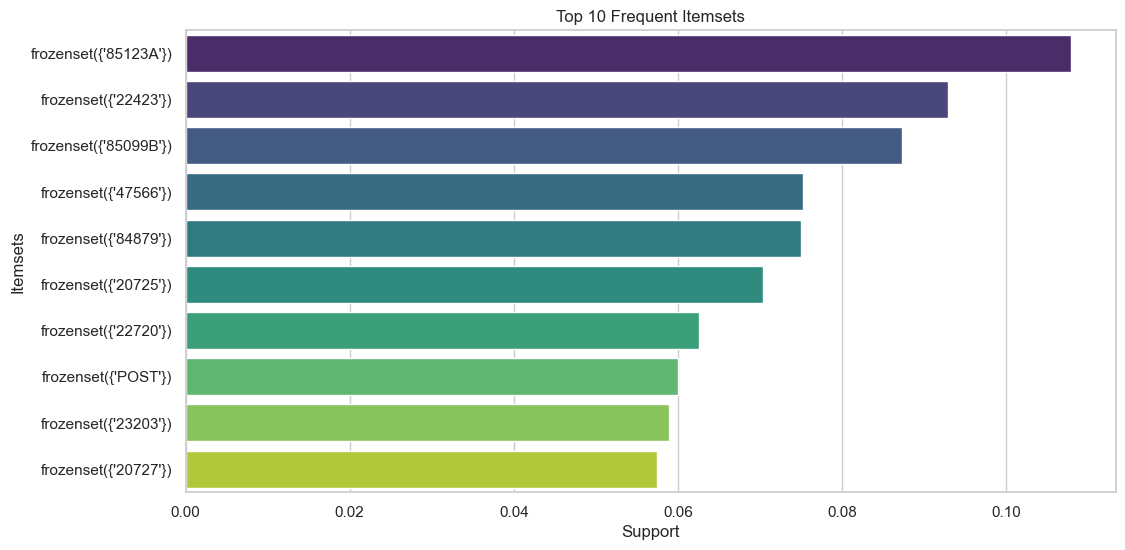

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot top 10 frequent itemsets
plt.figure(figsize=(12, 6))
top_items = frequent_itemsets.nlargest(10, 'support')
sns.barplot(x=top_items['support'], y=top_items['itemsets'].astype(str), palette="viridis")

plt.xlabel("Support")
plt.ylabel("Itemsets")
plt.title("Top 10 Frequent Itemsets")
plt.show()


#### Scatter Plot of Association Rules

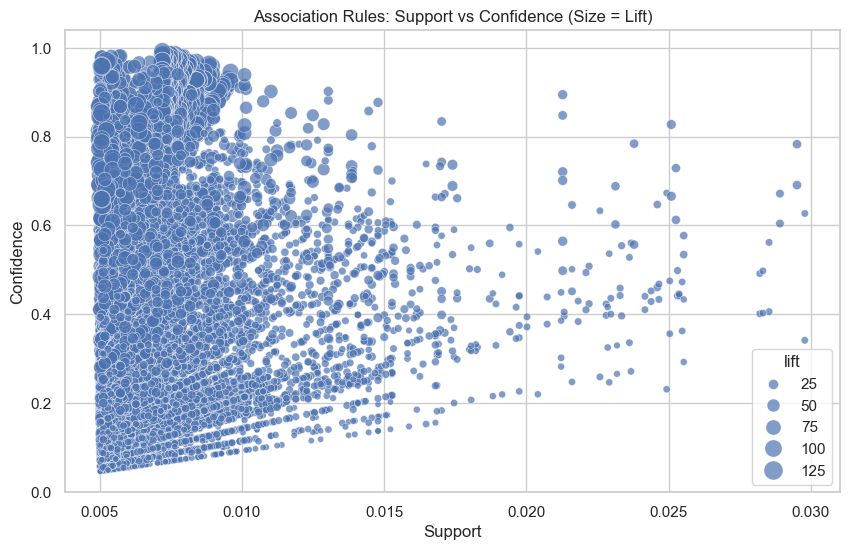

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rules["support"], y=rules["confidence"], size=rules["lift"], sizes=(20, 200), alpha=0.7)

plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Association Rules: Support vs Confidence (Size = Lift)")
plt.show()
